<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

0    3217
2    2525
5    2406
4    1596
1    1435
6    1317
3     859
Name: state, dtype: int64

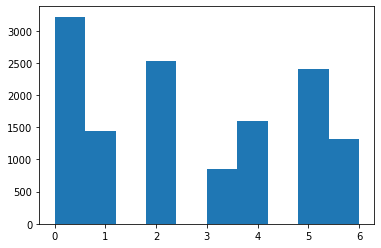

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 12, 22),
 datetime.date(2022, 12, 10),
 datetime.date(2012, 12, 12),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 12, 22), datetime.date(2022, 12, 10))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/max(n - 1, 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_45660/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_45660/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_45660/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_45660/2514616766.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/max(n - 1, 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000299,0.997806,1.001278,0.996355,1.001674,1.002588,1.001316,1.015429
AA,1.000264,0.997164,1.001383,1.001526,1.000112,1.001939,1.000856,1.001066
AAIC,0.999497,0.997569,1.000394,1.002871,1.001769,1.001602,0.999695,1.019784
AAL,0.999932,0.995708,1.002330,0.998838,1.000592,1.000572,1.001918,1.024855
AAME,0.999971,0.997656,1.001455,1.000953,1.001078,1.000856,1.000189,1.000463


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000556,0.999687,0.996913,1.004224,1.004604,1.004293,0.998342,1.038174
ZTR,1.000194,0.999190,1.000411,0.999993,1.000614,1.000819,1.000709,1.000288
ZUMZ,1.000136,0.997184,1.001280,0.990061,1.000354,1.000587,1.002077,1.007637
ZWS,1.000072,0.996836,0.998527,1.002157,1.001235,1.001835,1.001571,1.019815
ZYXI,1.000495,0.999181,1.001521,0.973428,1.000590,1.000852,1.000603,1.025934


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [30]:
CURRENT_STATE# = 0

0

In [31]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]


if CURRENT_STATE == 0:
    df['weighted'] = (
        0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar)
elif CURRENT_STATE == 1:
    df['weighted'] = (
        0.6*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
#elif CURRENT_STATE == ...
elif CURRENT_STATE == 7:
    df['weighted'] = (
        0.3*df[f'dar_{CURRENT_STATE}']
        + 0.5*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
ELC,1.001272,1.004072,0.998626,1.010814,0.999217,1.002547,1.000486,0.987810,1.002967
FSI,1.001295,1.002691,0.998910,1.020989,1.002200,1.000148,1.001149,1.023928,1.002034
GCBC,1.000721,1.001126,1.000388,0.994351,1.000672,1.000543,1.000573,0.992884,1.000971
MICS,0.999230,1.001598,0.998333,1.018131,0.997684,0.998228,0.997673,0.995323,1.000798
LFMD,1.000428,1.000748,1.001277,1.006993,1.002461,0.999393,0.998815,1.009025,1.000737


In [32]:
df.mean(), df.median()

(dar         1.000166
 dar_0       0.998213
 dar_1       1.000646
 dar_2       0.998509
 dar_3       1.000939
 dar_4       1.001336
 dar_5       1.000871
 dar_6       1.008521
 weighted    0.998846
 dtype: float64,
 dar         1.000264
 dar_0       0.998412
 dar_1       1.000705
 dar_2       1.000376
 dar_3       1.000927
 dar_4       1.001338
 dar_5       1.000873
 dar_6       1.006396
 weighted    0.999030
 dtype: float64)

In [63]:
always_exclude = ['NXN', 'NXP']
exclude = {
    0: ['CTSH', 'ELC', 'ORLY', 'WTRG'], 
    1: ['DTST', 'FSI'],
    7: ['ELC']}

In [64]:
best_weighted = [
    s for s in df.index
    if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [72]:
print(sorted(best_weighted))
#sorted(best_weighted)

['ABST', 'AGI', 'APT', 'BCTF', 'CEF', 'CZFS', 'DGX', 'ESOA', 'FCN', 'FNV', 'FSI', 'GCBC', 'HMY', 'LFMD', 'MICS', 'MRTI', 'MTA', 'NEN', 'UTMD', 'YORW']


In [66]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
FSI,1.001295,1.002691,0.998910,1.020989,1.002200,1.000148,1.001149,1.023928,1.002034
GCBC,1.000721,1.001126,1.000388,0.994351,1.000672,1.000543,1.000573,0.992884,1.000971
MICS,0.999230,1.001598,0.998333,1.018131,0.997684,0.998228,0.997673,0.995323,1.000798
LFMD,1.000428,1.000748,1.001277,1.006993,1.002461,0.999393,0.998815,1.009025,1.000737
MTA,1.000487,1.000939,0.999716,1.002113,1.000762,0.999784,1.001517,0.973440,1.000726
ESOA,0.999878,1.001081,0.999076,0.975340,1.001580,0.998729,0.999669,0.972680,1.000640
FNV,1.000641,1.000503,1.001142,1.010871,1.000009,1.000978,1.000370,0.994082,1.000594
NEN,1.000680,1.000419,1.000331,1.001245,1.000701,1.000841,1.001234,0.999047,1.000462
HMY,0.999986,1.000590,0.999809,1.002148,0.998973,0.999275,0.999981,1.005617,1.000391
APT,1.000266,1.000631,0.998958,1.000549,0.999233,1.000409,1.000991,1.008767,1.000391


In [67]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [68]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,ABST,AGI,APT,BCTF,CEF,CZFS,DGX,ESOA,FCN,FNV,FSI,GCBC,HMY,LFMD,MICS,MRTI,MTA,NEN,UTMD,YORW
Date,,,,,,,,,,,,,,,,,,,,
2022-12-05,9.61,9.76,4.00,13.4,17.190001,72.379997,148.919998,2.73,169.860001,143.029999,3.23,73.400002,3.44,2.61,5.0700,260.00000,5.30,72.250000,101.879997,45.820000
2022-12-06,9.32,9.70,4.04,13.4,17.150000,73.300003,148.970001,2.77,165.179993,141.949997,3.07,73.610001,3.50,2.42,5.1800,260.00000,5.18,72.500000,97.250000,45.810001
2022-12-07,9.41,9.95,4.03,13.4,17.420000,72.800003,149.000000,2.67,168.570007,142.809998,3.20,73.779999,3.50,2.48,5.4000,279.98999,5.18,71.500000,98.900002,45.869999
2022-12-08,9.37,10.04,4.09,13.4,17.570000,72.339996,150.500000,2.82,164.020004,143.619995,3.22,74.910004,3.51,2.49,4.8100,284.00000,5.24,69.989998,101.550003,46.599998
2022-12-09,9.33,9.84,4.01,13.5,17.700001,72.989998,148.850006,2.83,162.000000,140.809998,3.45,72.970001,3.45,2.48,4.6899,300.00000,5.29,70.699997,100.120003,46.209999


In [69]:
data = pd.concat([data, states], axis=1)

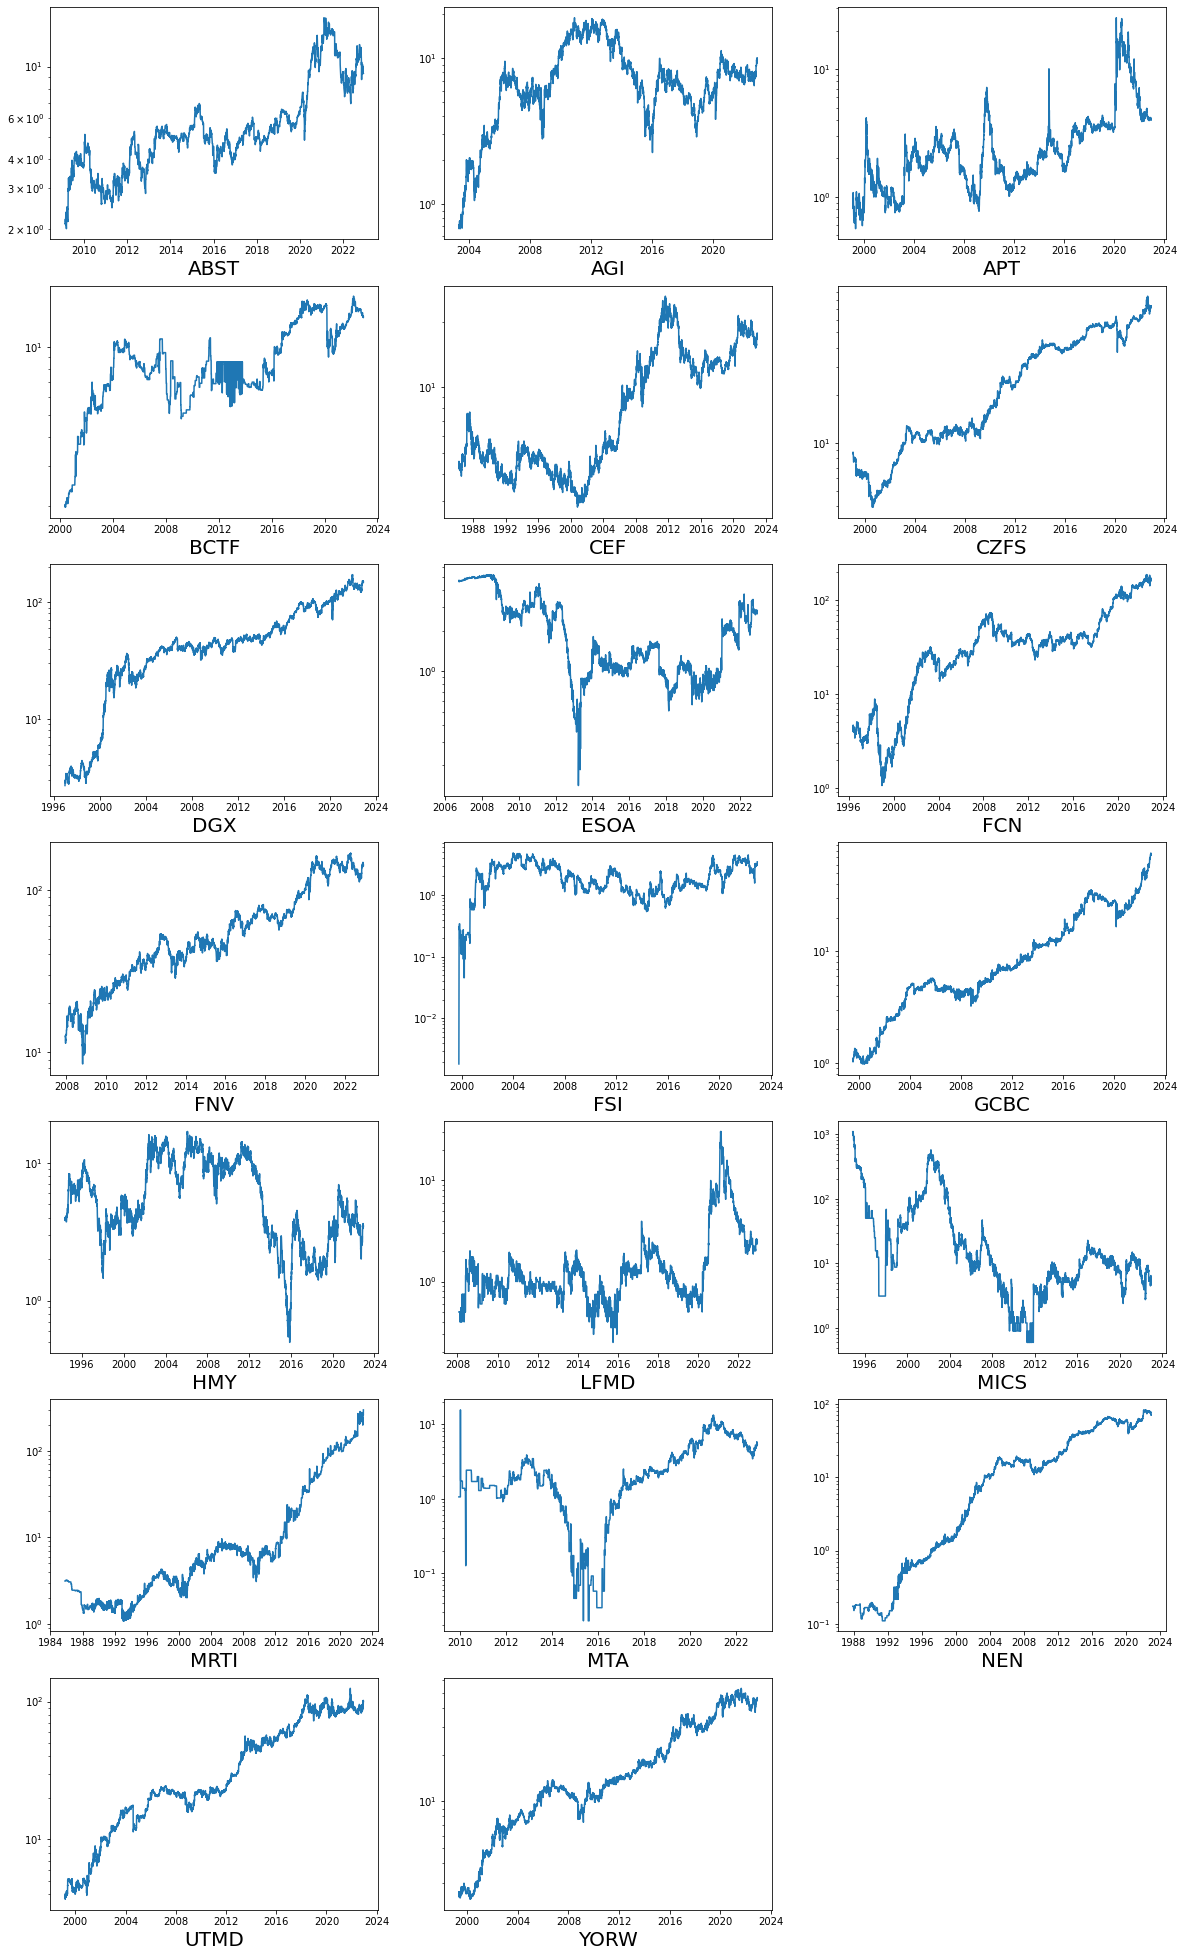

In [70]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

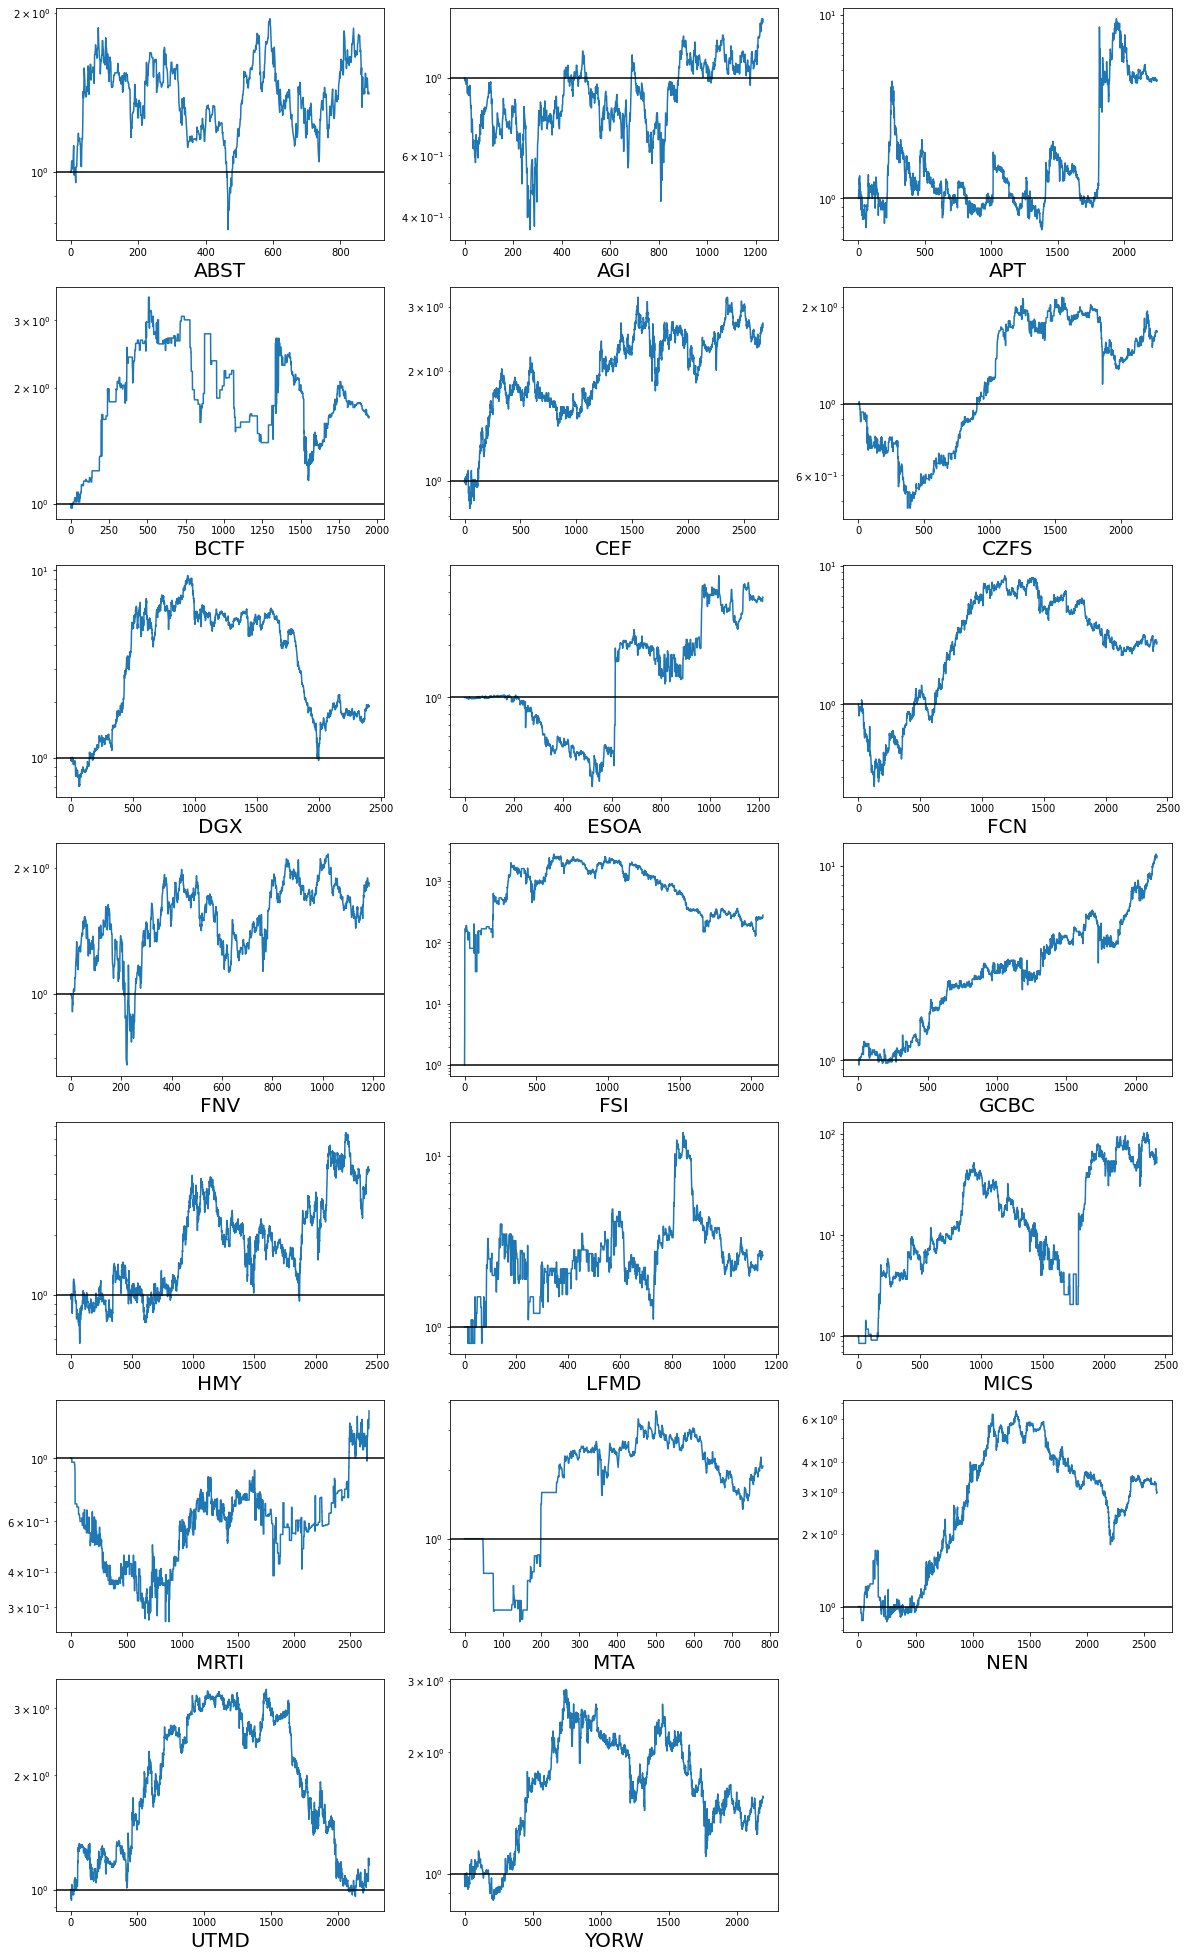

In [71]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.axhline(y=dr[0], color='k')
    plt.yscale('log')
    plt.xlabel(sym);